In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/kaggle/input/labelclassification/reviewsDataset.csv")
df.head()

,reviewContent,ground_truth_aspects
0,"আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড ...","product, packaging"
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...","product, seller, packaging"
2,আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে ...,"product, seller"
3,"যেমন ওর্ডার করেছি তেমন পেয়েছি,প্যাকেটিং ভালো ছ...","product, packaging, seller"
4,১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্য...,"product, delivery, seller"


In [3]:
df.shape

(1648, 2)

In [4]:
df = df.dropna()

In [5]:
df.shape

(1581, 2)

In [6]:
# Create a set to hold unique aspects
unique_aspects = set()

# Split the aspects and update the unique_aspects set
df['ground_truth_aspects'].str.split(', ').apply(unique_aspects.update)

# Strip spaces from unique aspects and remove any empty strings
unique_aspects = {aspect.strip() for aspect in unique_aspects if aspect.strip()}

# Create a new column for each unique aspect and initialize with 0
for aspect in unique_aspects:
    df[aspect] = 0

# Populate the columns based on the aspects present in each row
for index, row in df.iterrows():
    aspects = [aspect.strip() for aspect in row['ground_truth_aspects'].split(', ')]
    for aspect in aspects:
        if aspect:  # only update if aspect is not an empty string
            df.at[index, aspect] = 1

In [7]:
df.head()

,reviewContent,ground_truth_aspects,packaging product,"seller,shelf",price,"product,price",packaging,product,rider,delivery,shelf,service,seller
0,"আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড ...","product, packaging",0,0,0,0,1,1,0,0,0,0,0
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...","product, seller, packaging",0,0,0,0,1,1,0,0,0,0,1
2,আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে ...,"product, seller",0,0,0,0,0,1,0,0,0,0,1
3,"যেমন ওর্ডার করেছি তেমন পেয়েছি,প্যাকেটিং ভালো ছ...","product, packaging, seller",0,0,0,0,1,1,0,0,0,0,1
4,১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্য...,"product, delivery, seller",0,0,0,0,0,1,0,1,0,0,1


In [8]:
df.columns

Index(['reviewContent', 'ground_truth_aspects', 'packaging  product',
       'seller,shelf', 'price', 'product,price', 'packaging', 'product',
       'rider', 'delivery', 'shelf', 'service', 'seller'],
      dtype='object')

In [9]:
drop_columns = ["ground_truth_aspects", "packaging  product", "seller,shelf", "product,price"]
df = df.drop(columns=drop_columns, axis = 1)

In [10]:
df.head()

,reviewContent,price,packaging,product,rider,delivery,shelf,service,seller
0,"আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড ...",0,1,1,0,0,0,0,0
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...",0,1,1,0,0,0,0,1
2,আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে ...,0,0,1,0,0,0,0,1
3,"যেমন ওর্ডার করেছি তেমন পেয়েছি,প্যাকেটিং ভালো ছ...",0,1,1,0,0,0,0,1
4,১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্য...,0,0,1,0,1,0,0,1


In [11]:
df.reviewContent[2]

'আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে নিতে পারেন যে রকম কথা ছিল সেই রকম দিসে ধ্যনবাদ দারাজ এবং সেলার '

In [12]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [13]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (1106, 9), Test: (237, 9), Valid: (238, 9)


In [14]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 150
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # threshold for the sigmoid
     

In [15]:
from transformers import BertTokenizer, BertModel

import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
# Test the tokenizer
test_text = "আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড চেক করে দেখলাম অনেক ভালই! আপনার চোখ বন্ধ করে ভরসা করে নিতে পারেন! প্রোডাক্টটি যখন আমার হাতে এসেছিল তখন ইনটেক ছিল!"
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings
     

{'input_ids': tensor([[  101,  1348, 29909, 29913, 29914, 29906, 29900, 29909, 29915, 29909,
         29909, 29914, 29913,  1010,  1367, 29908, 29917, 29914, 29896, 29914,
         29889, 29895, 29895, 29915,  1347, 29902, 29917, 29889,  1369, 29914,
         29909, 29917, 29914,   999,  1376, 29914, 29886, 29902, 29896,  1356,
         29917, 29889,  1353, 29908, 29917,  1364, 29917, 29890, 29909,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}

In [18]:
df_train['reviewContent']

1359    "পণ্য ও গুণমান খুব ভালো মনে হয় আমার কাছে, আপন...
672     আলহামদুলিল্লাহ্ সব দিকেই পারফেক্ট ছিলো। সবাই ন...
736             নতুন উৎপাদিত প্রোডাক্ট। থ্যাংকস টু সেলার।
966     প্রোডাক্ট সম্পর্কে বলার কিছুই নাই, কারণ আমার স...
223     আলহামদুলিল্লাহ ভালো মতই পেয়েছি আমি সবসময় দারাজ...
                              ...                        
936     শেষমেশ কন্টেইনারসহ দেওয়া হয়েছে, প্রথমে বলছিল...
1358    কফি অসাধারণ ছিল। কন্টেইনার এর লোভে নেওয়া তবে ক...
236     ★★ রিভিউ করেছেন লিমন আজাদ (সানি) ★★\nপ্রোডাক্ট...
608                             খুব সুন্দর এবং সুস্বাদু 🥰
729                                    অরিজিনাল পণ্য গুলো
Name: reviewContent, Length: 1106, dtype: object

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['reviewContent'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }
     

In [20]:
target_list = list(df.columns)
target_list

['reviewContent',
 'price',
 'packaging',
 'product',
 'rider',
 'delivery',
 'shelf',
 'service',
 'seller']

In [21]:
target_list = target_list[1:]

In [22]:
target_list

['price',
 'packaging',
 'product',
 'rider',
 'delivery',
 'shelf',
 'service',
 'seller']

In [23]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [24]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101,  1000,  1367, 29897, 29907,  1352,  1355, 29897, 29906, 29914,
         29902,  1354, 29904,  1369, 29914, 29909, 29917, 29914,  1370, 29902,
         29917,  1377, 29907,  1348, 29906, 29914, 29908,  1353, 29914, 29893,
         29917,  1010,  1348, 29903, 29902, 29915,  1371, 29900, 29915,  1351,
         29885,  1367, 29897, 29907, 29895, 29915,  1353, 29915, 29902, 29898,
         29917,  1356, 29914, 29902,  1000,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [25]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [26]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 8)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [27]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [28]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         
     

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [30]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

**Model Training**

In [31]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "MLTC_model_state.bin")
        best_accuracy = val_acc
        
# https://github.com/dtolk/multilabel-BERT/blob/master/notebooks/multi_label_text_classification_BERT.ipynb

Epoch 1/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.5699, val_loss=0.4574 train_acc=0.7423, val_acc=0.8325
Epoch 2/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4537, val_loss=0.4210 train_acc=0.8282, val_acc=0.8330
Epoch 3/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4296, val_loss=0.4042 train_acc=0.8284, val_acc=0.8340
Epoch 4/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4190, val_loss=0.3947 train_acc=0.8299, val_acc=0.8440
Epoch 5/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.4006, val_loss=0.3793 train_acc=0.8343, val_acc=0.8435
Epoch 6/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3857, val_loss=0.3653 train_acc=0.8429, val_acc=0.8561
Epoch 7/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3706, val_loss=0.3645 train_acc=0.8482, val_acc=0.8598
Epoch 8/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3596, val_loss=0.3472 train_acc=0.8558, val_acc=0.8661
Epoch 9/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3417, val_loss=0.3405 train_acc=0.8647, val_acc=0.8687
Epoch 10/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3305, val_loss=0.3230 train_acc=0.8683, val_acc=0.8808
Epoch 11/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3172, val_loss=0.3134 train_acc=0.8790, val_acc=0.8818
Epoch 12/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.3065, val_loss=0.2992 train_acc=0.8835, val_acc=0.8902
Epoch 13/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2890, val_loss=0.2832 train_acc=0.8982, val_acc=0.9060
Epoch 14/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2751, val_loss=0.2788 train_acc=0.9072, val_acc=0.9007
Epoch 15/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2609, val_loss=0.2578 train_acc=0.9125, val_acc=0.9186
Epoch 16/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2452, val_loss=0.2488 train_acc=0.9185, val_acc=0.9165
Epoch 17/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2334, val_loss=0.2455 train_acc=0.9255, val_acc=0.9202
Epoch 18/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2219, val_loss=0.2384 train_acc=0.9283, val_acc=0.9238
Epoch 19/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2112, val_loss=0.2392 train_acc=0.9378, val_acc=0.9275
Epoch 20/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.2034, val_loss=0.2203 train_acc=0.9402, val_acc=0.9275
Epoch 21/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1929, val_loss=0.2220 train_acc=0.9435, val_acc=0.9265
Epoch 22/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1821, val_loss=0.2070 train_acc=0.9465, val_acc=0.9275
Epoch 23/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1706, val_loss=0.2264 train_acc=0.9507, val_acc=0.9233
Epoch 24/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1658, val_loss=0.2174 train_acc=0.9561, val_acc=0.9275
Epoch 25/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1549, val_loss=0.2066 train_acc=0.9607, val_acc=0.9301
Epoch 26/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1511, val_loss=0.2149 train_acc=0.9598, val_acc=0.9291
Epoch 27/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1417, val_loss=0.2190 train_acc=0.9629, val_acc=0.9286
Epoch 28/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1363, val_loss=0.2028 train_acc=0.9629, val_acc=0.9286
Epoch 29/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1257, val_loss=0.2036 train_acc=0.9689, val_acc=0.9275
Epoch 30/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1180, val_loss=0.1972 train_acc=0.9734, val_acc=0.9349
Epoch 31/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1115, val_loss=0.2100 train_acc=0.9765, val_acc=0.9286
Epoch 32/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1062, val_loss=0.2015 train_acc=0.9795, val_acc=0.9307
Epoch 33/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.1012, val_loss=0.1973 train_acc=0.9788, val_acc=0.9291
Epoch 34/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0959, val_loss=0.1971 train_acc=0.9819, val_acc=0.9317
Epoch 35/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0914, val_loss=0.1914 train_acc=0.9838, val_acc=0.9338
Epoch 36/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0871, val_loss=0.1870 train_acc=0.9837, val_acc=0.9333
Epoch 37/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0796, val_loss=0.1977 train_acc=0.9878, val_acc=0.9296
Epoch 38/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0776, val_loss=0.2015 train_acc=0.9893, val_acc=0.9301
Epoch 39/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0739, val_loss=0.1937 train_acc=0.9888, val_acc=0.9322
Epoch 40/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0699, val_loss=0.1926 train_acc=0.9902, val_acc=0.9349
Epoch 41/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0640, val_loss=0.2028 train_acc=0.9922, val_acc=0.9259
Epoch 42/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0616, val_loss=0.1911 train_acc=0.9920, val_acc=0.9349
Epoch 43/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0604, val_loss=0.2127 train_acc=0.9912, val_acc=0.9270
Epoch 44/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0558, val_loss=0.1982 train_acc=0.9937, val_acc=0.9301
Epoch 45/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0529, val_loss=0.2027 train_acc=0.9940, val_acc=0.9307
Epoch 46/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0505, val_loss=0.2027 train_acc=0.9954, val_acc=0.9301
Epoch 47/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0475, val_loss=0.2022 train_acc=0.9958, val_acc=0.9343
Epoch 48/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0467, val_loss=0.2091 train_acc=0.9953, val_acc=0.9286
Epoch 49/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0447, val_loss=0.2033 train_acc=0.9957, val_acc=0.9307
Epoch 50/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0410, val_loss=0.1925 train_acc=0.9975, val_acc=0.9364
Epoch 51/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0390, val_loss=0.2004 train_acc=0.9966, val_acc=0.9322
Epoch 52/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0375, val_loss=0.2042 train_acc=0.9971, val_acc=0.9312
Epoch 53/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0359, val_loss=0.1981 train_acc=0.9974, val_acc=0.9359
Epoch 54/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0351, val_loss=0.1959 train_acc=0.9974, val_acc=0.9370
Epoch 55/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0336, val_loss=0.1949 train_acc=0.9981, val_acc=0.9375
Epoch 56/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0314, val_loss=0.1954 train_acc=0.9990, val_acc=0.9386
Epoch 57/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0296, val_loss=0.1953 train_acc=0.9991, val_acc=0.9386
Epoch 58/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0292, val_loss=0.1994 train_acc=0.9986, val_acc=0.9312
Epoch 59/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0295, val_loss=0.2027 train_acc=0.9985, val_acc=0.9354
Epoch 60/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0263, val_loss=0.1920 train_acc=0.9988, val_acc=0.9401
Epoch 61/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0257, val_loss=0.1936 train_acc=0.9990, val_acc=0.9364
Epoch 62/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0246, val_loss=0.1955 train_acc=0.9994, val_acc=0.9349
Epoch 63/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0233, val_loss=0.1973 train_acc=0.9992, val_acc=0.9359
Epoch 64/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0237, val_loss=0.2011 train_acc=0.9992, val_acc=0.9364
Epoch 65/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0225, val_loss=0.2027 train_acc=0.9990, val_acc=0.9349
Epoch 66/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0210, val_loss=0.2073 train_acc=0.9997, val_acc=0.9322
Epoch 67/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0217, val_loss=0.2068 train_acc=0.9989, val_acc=0.9349
Epoch 68/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0207, val_loss=0.2044 train_acc=0.9992, val_acc=0.9338
Epoch 69/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0200, val_loss=0.2053 train_acc=0.9990, val_acc=0.9328
Epoch 70/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0199, val_loss=0.1957 train_acc=0.9994, val_acc=0.9380
Epoch 71/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0190, val_loss=0.2020 train_acc=0.9994, val_acc=0.9333
Epoch 72/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0183, val_loss=0.2023 train_acc=0.9995, val_acc=0.9359
Epoch 73/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0168, val_loss=0.2009 train_acc=0.9999, val_acc=0.9391
Epoch 74/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0162, val_loss=0.2043 train_acc=0.9998, val_acc=0.9401
Epoch 75/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0160, val_loss=0.2042 train_acc=0.9997, val_acc=0.9364
Epoch 76/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0153, val_loss=0.2097 train_acc=0.9997, val_acc=0.9364
Epoch 77/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0149, val_loss=0.2071 train_acc=0.9998, val_acc=0.9412
Epoch 78/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0149, val_loss=0.2023 train_acc=0.9997, val_acc=0.9401
Epoch 79/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0145, val_loss=0.2073 train_acc=0.9997, val_acc=0.9386
Epoch 80/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0138, val_loss=0.2058 train_acc=0.9998, val_acc=0.9391
Epoch 81/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0137, val_loss=0.2047 train_acc=0.9997, val_acc=0.9375
Epoch 82/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0134, val_loss=0.2210 train_acc=0.9995, val_acc=0.9349
Epoch 83/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0131, val_loss=0.2130 train_acc=0.9998, val_acc=0.9386
Epoch 84/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0125, val_loss=0.2054 train_acc=0.9999, val_acc=0.9354
Epoch 85/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0122, val_loss=0.2138 train_acc=0.9998, val_acc=0.9354
Epoch 86/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0117, val_loss=0.2175 train_acc=0.9999, val_acc=0.9354
Epoch 87/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0112, val_loss=0.2100 train_acc=0.9999, val_acc=0.9396
Epoch 88/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0111, val_loss=0.2121 train_acc=0.9999, val_acc=0.9401
Epoch 89/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0112, val_loss=0.2151 train_acc=0.9999, val_acc=0.9401
Epoch 90/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0110, val_loss=0.2144 train_acc=0.9998, val_acc=0.9349
Epoch 91/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0110, val_loss=0.2182 train_acc=0.9998, val_acc=0.9370
Epoch 92/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0105, val_loss=0.2162 train_acc=0.9998, val_acc=0.9391
Epoch 93/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0103, val_loss=0.2226 train_acc=0.9998, val_acc=0.9354
Epoch 94/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0105, val_loss=0.2174 train_acc=0.9997, val_acc=0.9359
Epoch 95/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0103, val_loss=0.2159 train_acc=0.9998, val_acc=0.9396
Epoch 96/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0096, val_loss=0.2170 train_acc=0.9998, val_acc=0.9412
Epoch 97/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0098, val_loss=0.2247 train_acc=0.9998, val_acc=0.9375
Epoch 98/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0095, val_loss=0.2234 train_acc=0.9999, val_acc=0.9359
Epoch 99/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0095, val_loss=0.2214 train_acc=0.9997, val_acc=0.9380
Epoch 100/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0093, val_loss=0.2288 train_acc=0.9999, val_acc=0.9322
Epoch 101/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0086, val_loss=0.2234 train_acc=0.9998, val_acc=0.9380
Epoch 102/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0083, val_loss=0.2293 train_acc=0.9998, val_acc=0.9359
Epoch 103/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0085, val_loss=0.2239 train_acc=0.9998, val_acc=0.9370
Epoch 104/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0084, val_loss=0.2288 train_acc=0.9998, val_acc=0.9370
Epoch 105/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0084, val_loss=0.2248 train_acc=0.9999, val_acc=0.9364
Epoch 106/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0077, val_loss=0.2265 train_acc=0.9999, val_acc=0.9375
Epoch 107/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0076, val_loss=0.2292 train_acc=0.9998, val_acc=0.9391
Epoch 108/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0075, val_loss=0.2305 train_acc=0.9997, val_acc=0.9375
Epoch 109/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0073, val_loss=0.2314 train_acc=0.9999, val_acc=0.9391
Epoch 110/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0070, val_loss=0.2263 train_acc=0.9999, val_acc=0.9386
Epoch 111/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0067, val_loss=0.2259 train_acc=1.0000, val_acc=0.9401
Epoch 112/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0068, val_loss=0.2307 train_acc=0.9999, val_acc=0.9370
Epoch 113/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0074, val_loss=0.2329 train_acc=0.9998, val_acc=0.9380
Epoch 114/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0065, val_loss=0.2301 train_acc=0.9998, val_acc=0.9364
Epoch 115/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0067, val_loss=0.2280 train_acc=0.9998, val_acc=0.9386
Epoch 116/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0062, val_loss=0.2407 train_acc=0.9999, val_acc=0.9380
Epoch 117/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0062, val_loss=0.2307 train_acc=0.9999, val_acc=0.9370
Epoch 118/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0060, val_loss=0.2366 train_acc=0.9999, val_acc=0.9364
Epoch 119/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0058, val_loss=0.2408 train_acc=0.9999, val_acc=0.9338
Epoch 120/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0058, val_loss=0.2332 train_acc=0.9999, val_acc=0.9380
Epoch 121/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0060, val_loss=0.2322 train_acc=0.9997, val_acc=0.9396
Epoch 122/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0058, val_loss=0.2375 train_acc=0.9998, val_acc=0.9359
Epoch 123/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0054, val_loss=0.2376 train_acc=0.9998, val_acc=0.9391
Epoch 124/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0056, val_loss=0.2384 train_acc=0.9998, val_acc=0.9396
Epoch 125/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0059, val_loss=0.2505 train_acc=0.9995, val_acc=0.9343
Epoch 126/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0056, val_loss=0.2396 train_acc=0.9998, val_acc=0.9401
Epoch 127/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0053, val_loss=0.2459 train_acc=1.0000, val_acc=0.9364
Epoch 128/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0051, val_loss=0.2401 train_acc=0.9998, val_acc=0.9396
Epoch 129/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0052, val_loss=0.2314 train_acc=0.9998, val_acc=0.9417
Epoch 130/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0049, val_loss=0.2407 train_acc=0.9999, val_acc=0.9396
Epoch 131/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0049, val_loss=0.2370 train_acc=0.9998, val_acc=0.9428
Epoch 132/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0045, val_loss=0.2397 train_acc=0.9999, val_acc=0.9417
Epoch 133/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0047, val_loss=0.2433 train_acc=0.9998, val_acc=0.9401
Epoch 134/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0049, val_loss=0.2480 train_acc=0.9999, val_acc=0.9375
Epoch 135/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0050, val_loss=0.2602 train_acc=0.9998, val_acc=0.9333
Epoch 136/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0049, val_loss=0.2402 train_acc=0.9997, val_acc=0.9391
Epoch 137/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0047, val_loss=0.2474 train_acc=0.9998, val_acc=0.9375
Epoch 138/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0045, val_loss=0.2413 train_acc=0.9998, val_acc=0.9375
Epoch 139/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0044, val_loss=0.2398 train_acc=0.9998, val_acc=0.9407
Epoch 140/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0044, val_loss=0.2499 train_acc=0.9998, val_acc=0.9386
Epoch 141/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0044, val_loss=0.2506 train_acc=0.9998, val_acc=0.9386
Epoch 142/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0041, val_loss=0.2450 train_acc=0.9998, val_acc=0.9396
Epoch 143/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0040, val_loss=0.2478 train_acc=0.9999, val_acc=0.9407
Epoch 144/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0039, val_loss=0.2454 train_acc=0.9999, val_acc=0.9412
Epoch 145/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0038, val_loss=0.2447 train_acc=0.9998, val_acc=0.9396
Epoch 146/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0039, val_loss=0.2443 train_acc=0.9998, val_acc=0.9433
Epoch 147/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0039, val_loss=0.2471 train_acc=0.9999, val_acc=0.9412
Epoch 148/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0040, val_loss=0.2546 train_acc=0.9999, val_acc=0.9391
Epoch 149/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0043, val_loss=0.2549 train_acc=0.9995, val_acc=0.9417
Epoch 150/150


  0%|          | 0/35 [00:00<?, ?it/s]

train_loss=0.0047, val_loss=0.2542 train_acc=0.9994, val_acc=0.9386


In [32]:
import matplotlib.pyplot as plt

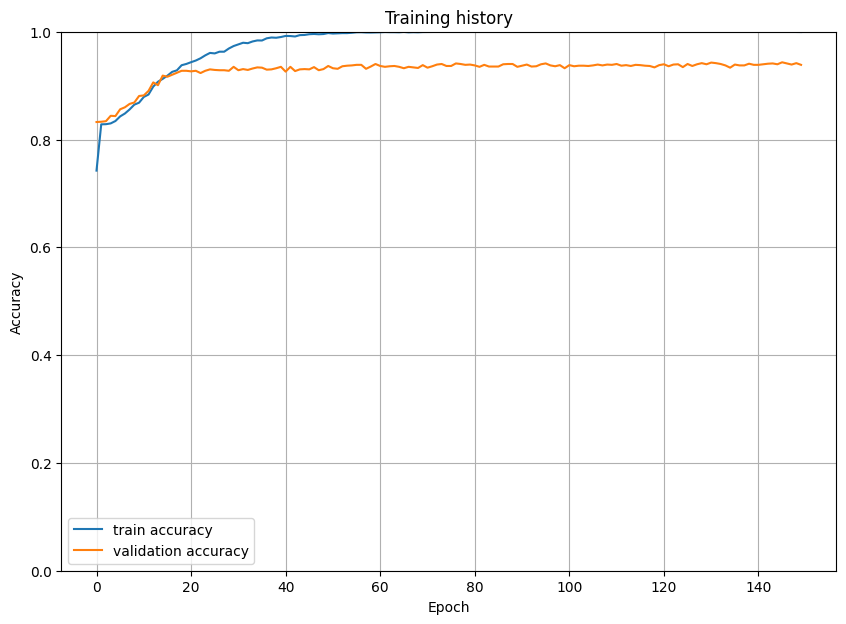

In [33]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

**Evaluation of the model**

In [34]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load("/kaggle/working/MLTC_model_state.bin"))
model = model.to(device)
     

In [35]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [36]:

# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.9319620253164557

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

In [38]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
        for data in data_loader:
            title = data["title"]
            ids = data["input_ids"].to(device, dtype = torch.long)
            mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data["targets"].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).detach().cpu()
            # thresholding at 0.5
            preds = outputs.round()
            targets = targets.detach().cpu()

            titles.extend(title)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

In [39]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [40]:
# sanity check
predictions.numpy()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:237 
predictions:torch.Size([237, 8]) 
prediction_probs:torch.Size([237, 8]) 
target_values:torch.Size([237, 8])


In [42]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

       price       0.85      0.89      0.87        44
   packaging       0.86      0.91      0.88        46
     product       0.86      0.84      0.85       159
       rider       0.78      0.70      0.74        10
    delivery       0.90      0.88      0.89        52
       shelf       1.00      1.00      1.00        20
     service       0.50      0.25      0.33        32
      seller       0.87      0.92      0.90        52

   micro avg       0.86      0.83      0.84       415
   macro avg       0.83      0.80      0.81       415
weighted avg       0.84      0.83      0.83       415
 samples avg       0.84      0.83      0.82       415



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# > **Inference**

In [43]:
# raw text
raw_text = """
১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্যে ডেলিভারি হয়েছে। বিক্রেতা খুবই সহানুভূতিশীল এবং ভালো ছিলেন। এই প্রোডাক্টটি এই বিক্রেতার কাছ থেকে কেনার জন্য অত্যন্ত সুপারিশ করছি।
"""

In [44]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([0., 0., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [45]:
# Correctly identified the topic of the paper: High energy physics
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
    if p==1:
        print(f"Label: {target_list[idx]}")

Title: 
১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্যে ডেলিভারি হয়েছে। বিক্রেতা খুবই সহানুভূতিশীল এবং ভালো ছিলেন। এই প্রোডাক্টটি এই বিক্রেতার কাছ থেকে কেনার জন্য অত্যন্ত সুপারিশ করছি।

Label: product
Label: delivery
Label: seller


In [46]:
df.reviewContent[4]

'১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্যে ডেলিভারি হয়েছে। বিক্রেতা খুবই সহানুভূতিশীল এবং ভালো ছিলেন। এই প্রোডাক্টটি এই বিক্রেতার কাছ থেকে কেনার জন্য অত্যন্ত সুপারিশ করছি।'

In [47]:
df

,reviewContent,price,packaging,product,rider,delivery,shelf,service,seller
0,"আলহামদুলিল্লাহ, প্রোডাক্টটি অনেক ভালো! সাউন্ড ...",0,1,1,0,0,0,0,0
1,"অসাধারণ একটা প্রডাক্ট হাতে পেলাম,সত্যিই অসাধার...",0,1,1,0,0,0,0,1
2,আসা করি যে ভালো হবে কিন্তু অনেক ভালো ছিল চালে ...,0,0,1,0,0,0,0,1
3,"যেমন ওর্ডার করেছি তেমন পেয়েছি,প্যাকেটিং ভালো ছ...",0,1,1,0,0,0,0,1
4,১০০% আসল প্রোডাক্ট। সিলেটের মধ্যে ৮ দিনের মধ্য...,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1643,পর্যাপ্ত মেয়াদ এবং প্যাকেজিং ভাল ছিল।ধন্যবাদ।,0,1,0,0,0,1,0,0
1644,"এই ১ম দারাজের থেকে ঠিকঠাক পন্য পেলাম, \n সাথে ...",0,0,1,0,0,0,0,0
1645,প্যাকেজিং এবং পণ্য উভয়ই অসাধারণ।,0,1,1,0,0,0,0,0
1646,"আরে ভাই, এটা বেবি আইটেম বাচ্চাদের দুধ, এতো ব্য...",1,0,1,0,0,1,1,0
